In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
import datetime
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-scoring/sample_submission.csv
/kaggle/input/sf-scoring/train.csv
/kaggle/input/sf-scoring/test.csv


In [2]:
DATA_DIR = '/kaggle/input/sf-scoring/'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
sample_submission.shape

(36349, 2)

In [4]:
df_test.shape

(36349, 18)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [8]:
sample_submission.head(5)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
# преобразуем дату в формат datetime
data['app_date'] = data.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [12]:
# посмотрим что по годам
data.app_date.dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

In [13]:
# выделим в отдельные столбцы "месяц", "день недели", "день месяца по порядку", "день года по порядку"
data['day_of_week'] = data.app_date.dt.day_of_week
data['day_of_month'] = data.app_date.dt.day
data['day_of_year'] = data.app_date.dt.day_of_year
data['month'] = data.app_date.dt.month

In [14]:
# посчитаем пропуски в education
data.education.isna().sum()

478

In [15]:
# Количество пропусков в столбце Education относительно небольшое, можно было бы удалить.
# Но мы поступим по другому.
# Заполним пропуски на медианные значения
mod = data.education.mode()[0]
data['education'] = data['education'].fillna(value=mod, axis=0)

In [16]:
data['decline_app_cnt'].value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
21        1
30        1
20        1
19        1
22        1
33        1
15        1
24        1
Name: decline_app_cnt, dtype: int64

In [17]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'day_of_month', 'day_of_year']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating', 'day_of_week', 'month']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


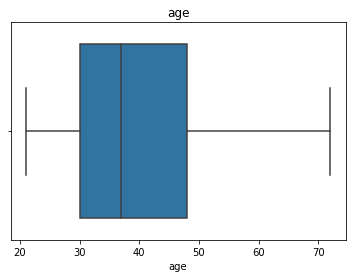

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


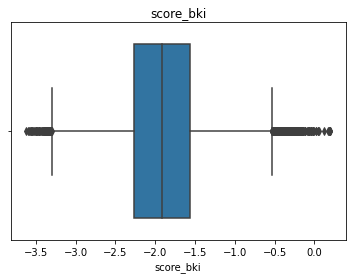

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


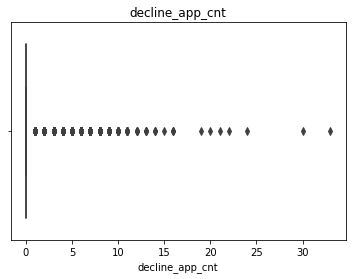

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


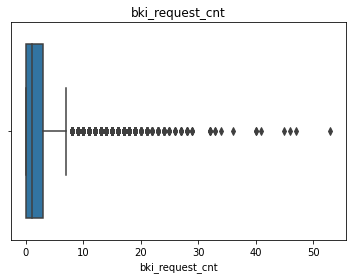

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


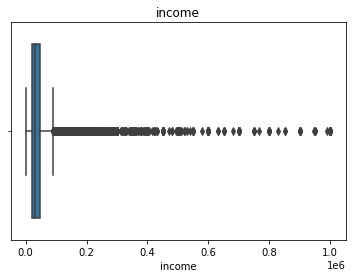

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


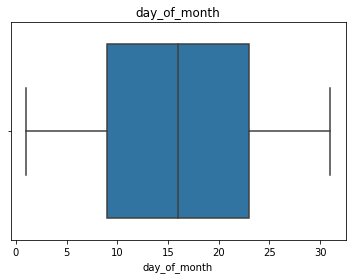

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


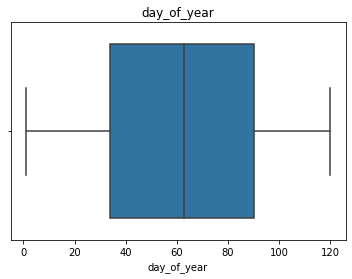

In [18]:
# проверим на выбросы num_cols
import matplotlib.pyplot as plt
import seaborn as sns
for i in num_cols:
    plt.figure()
    sns.boxplot(data[i])
    plt.title(i)
    plt.show()


In [19]:
def IQR_outlier(df: pd.DataFrame, column: object, verbose: bool=True) -> tuple:
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print('', format(i),':', "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)

In [20]:
for i in num_cols:
   low, high = IQR_outlier(data, i)
   if i == 'income':
      pass                          #Оставим income как есть
   elif i == 'decline_app_cnt':
     data[i] = data[i].apply(lambda x: data[i].median() if x>16 else x)
   elif i == 'bki_request_cnt':
      data[i] = data[i].apply(lambda x: data[i].median() if x>30 else x)
   else:
      data[i] = data[i].apply(lambda x: data[i].median() if x>high or x<low else x)

 age : Границы выбросов: [3.0, 75.0].
 score_bki : Границы выбросов: [-3.299251946250001, -0.5290698762499992].
 decline_app_cnt : Границы выбросов: [0.0, 0.0].
 bki_request_cnt : Границы выбросов: [-4.5, 7.5].
 income : Границы выбросов: [-22000.0, 90000.0].
 day_of_month : Границы выбросов: [-12.0, 44.0].
 day_of_year : Границы выбросов: [-50.0, 174.0].


<AxesSubplot:>

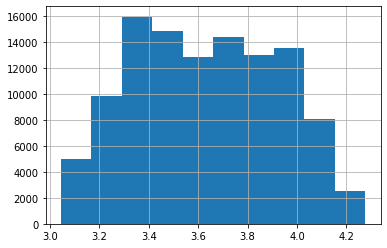

In [21]:
#Логарифмируем age
data['age'] = data['age'].apply(lambda w: np.log(w))
data.age.hist()

<AxesSubplot:>

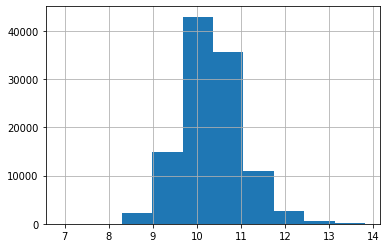

In [22]:
#Логарифмируем income
data['income'] = data['income'].apply(lambda w: np.log(w))
data.income.hist()

Так больше похоже на нормальное распределение

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


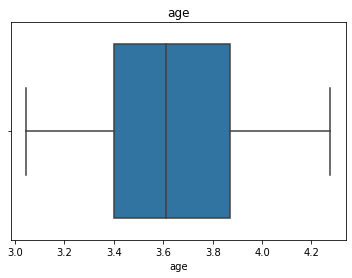

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


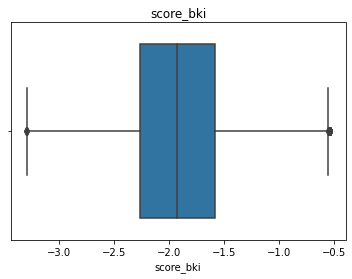

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


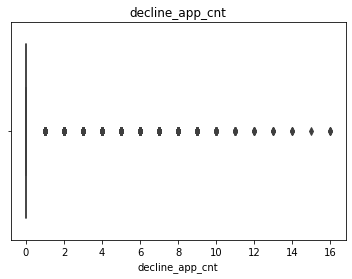

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


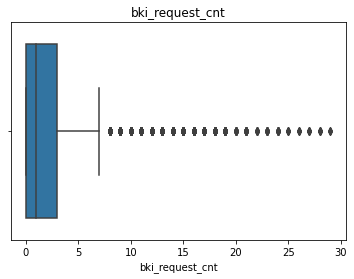

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


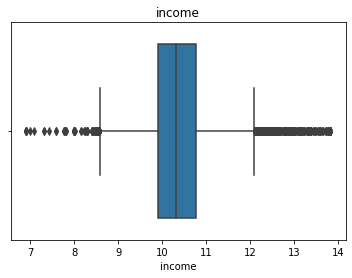

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


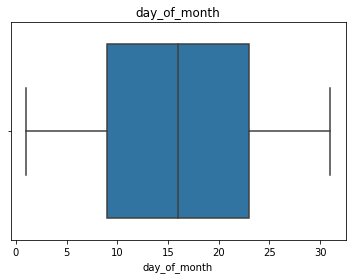

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


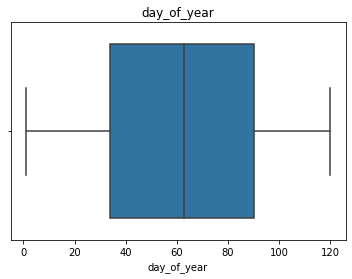

In [23]:
for i in num_cols:
    plt.figure()
    sns.boxplot(data[i])
    plt.title(i)
    plt.show()

<AxesSubplot:>

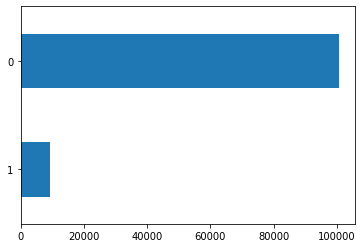

In [24]:
data['default'].value_counts(ascending=True).plot(kind='barh')

In [25]:
data.default.value_counts()

0    100776
1      9372
Name: default, dtype: int64

Целевая переменная несбалансирована - учтем при настройке модели

In [26]:
data = data.drop(columns = ['app_date', 'client_id'], axis = 1)

In [27]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

In [28]:
data['education'] = le.fit_transform(data['education'])

<AxesSubplot:>

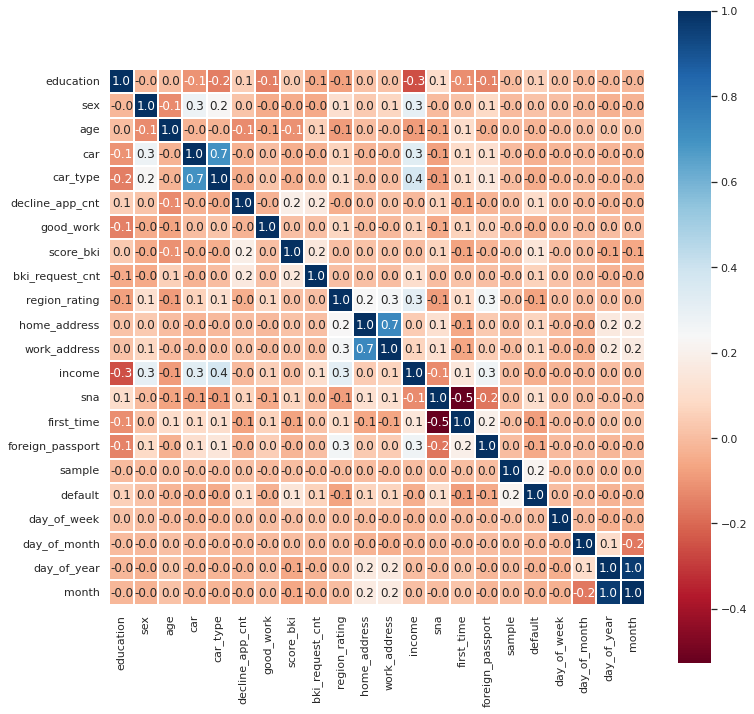

In [29]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(data.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [30]:
import sklearn
from sklearn.feature_selection import f_classif, mutual_info_classif

<AxesSubplot:>

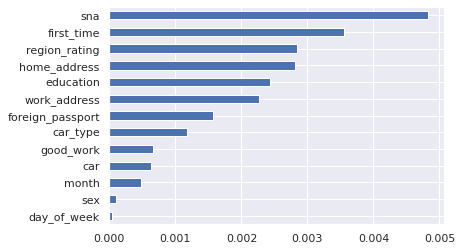

In [31]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

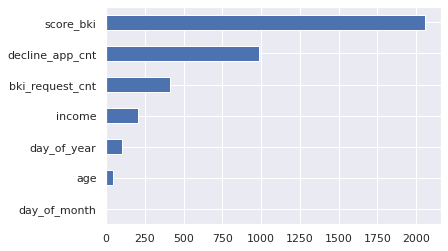

In [32]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Итак, кандидаты на исключение: 
*  'car', 'first_time', 'sex', 'good_work', 'foreign_passport', 'day_of_week', 'month'
*  'day_of_month', 'age', 'day_of_year', 'income', 'bki_request_cnt'

Но мы не будем ничего удалять. Как показала практика, точность выше со всеми признаками.

In [33]:
# преобразуем категориальные признаки в dummies
data = pd.get_dummies(data, columns=cat_cols)

In [34]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [35]:
#Стандартизируем наши данные
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [36]:
ss.fit(X, y)

StandardScaler()

In [37]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 49), (14760, 49), (59039,), (14760,))

In [39]:
#обрабатываем признаки
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [40]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [41]:
from sklearn.metrics import f1_score

In [42]:
logreg = LogisticRegression(C=1,solver='sag', max_iter=50, class_weight='balanced', tol=0.001, penalty='none', multi_class='ovr')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [43]:
f1 = f1_score(y_test, y_pred)

from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760



In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['None'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/class_weight.py", line 64, in compute_class_weight
    " got: %r" % class_weight)
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFail

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'l1'
	random_state: None
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False


In [46]:
# если качество нас устраивает, обучаем финальную модель на всех обучающи данных
logreg_final = LogisticRegression(C=1,solver='sag', max_iter=1000, class_weight='balanced', tol=0.001, penalty='none', multi_class='ovr')
logreg_final.fit(X, y)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                   multi_class='ovr', penalty='none', solver='sag', tol=0.001)

In [47]:
predict_submission = logreg_final.predict(test_data)

In [48]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [49]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.376737
std,31706.052195,0.484575
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [50]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
